<a href="https://www.kaggle.com/code/bukolaajayi/go-daddy-competition-project?scriptVersionId=119401279" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Goal:
To estimate or forecast the monthly density of microbusinesses in a specific area. 

In [1]:
#importing the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly.express as px

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
#reading the dataset
df_Sub = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')
df_Starter = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
df_Train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
df_Test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

In [3]:
#checking out number of rows and columns of each dataset
print(df_Train.shape)
print(df_Test.shape)
print(df_Sub.shape)
print(df_Starter.shape)

(122265, 7)
(25080, 3)
(25080, 2)
(3142, 26)


In [4]:
#information on the test dataset
df_Test.head(3)

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01


In [5]:
#unique dates in test dataset
df_Test.first_day_of_month.unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

Test dataset spans from, November 2022 through June 2023.

In [6]:
print('The minimum date given for the train dataset:', df_Test['first_day_of_month'].min())
print('The maximum date given for the train dataset:', df_Test['first_day_of_month'].max())

The minimum date given for the train dataset: 2022-11-01
The maximum date given for the train dataset: 2023-06-01


In [7]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [8]:
#information on train datset
df_Train.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198


In [9]:
df_Train.first_day_of_month.unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01'], dtype=object)

Train dataset spans from August 2019 through October 2022.

In [10]:
print('The number of states:', df_Train['state'].nunique())
print('The minimum date given for the train dataset:',  df_Train['first_day_of_month'].min())
print('The maximum date given for the train dataset:',  df_Train['first_day_of_month'].max())

The number of states: 51
The minimum date given for the train dataset: 2019-08-01
The maximum date given for the train dataset: 2022-10-01


Along with the row id, cfips, county, and state, first day of month, microbusiness density, and active fields are included in `train data`. 

Only row id, cfips, and first day of month are present in the `test data`. 

Microbusiness density for a specific cfips and at a specific first day of month is the value to be predicted.

## What number of cfips are there?
Let's now investigate the cfips data.

In [11]:
df_Train['cfips'].nunique(), df_Test['cfips'].nunique(), df_Starter['cfips'].nunique()

(3135, 3135, 3142)

- We have test and train data totaling 3135 cfips.
- There are 3142 cfips overall (according to census statistics).
- The train and test datasets do not contain all of the cfips for which we do have census data.

## Data Cleaning

In [12]:
#function to seperate the first day of the month from the cfips
def get_first_day_of_month(item):
    item = item.split('_')[1]
    return item

def get_cfips(item):
    item = item.split('_')[0]
    return item

In [13]:
#applying the defined function
df_Sub['first_day_of_month'] = df_Sub['row_id'].apply(get_first_day_of_month)
df_Sub['cfips'] = df_Sub['row_id'].apply(get_cfips)

In [14]:
#converting the date to datetime
df_Test['first_day_of_month'] = pd.to_datetime(df_Test['first_day_of_month'])
df_Train['first_day_of_month'] = pd.to_datetime(df_Train['first_day_of_month'])
df_Sub['first_day_of_month'] = pd.to_datetime(df_Sub['first_day_of_month'])

In [15]:
#converting the date to datetime
df_Test['first_day_of_month'] = pd.to_datetime(df_Test['first_day_of_month'])
df_Train['first_day_of_month'] = pd.to_datetime(df_Train['first_day_of_month'])
df_Sub['first_day_of_month'] = pd.to_datetime(df_Sub['first_day_of_month'])

In [16]:
df_Train['year'] = df_Train['first_day_of_month'].dt.year
df_Train['month'] = df_Train['first_day_of_month'].dt.month

In [17]:
#dropping the `row_id` column because the required information has been extracted
# df_Test.drop(['row_id'],axis = 1, inplace = True)
# df_Train.drop(['row_id'],axis = 1, inplace = True)
# df_Sub.drop(['row_id'],axis = 1, inplace = True)

In [18]:
#merging the train and starter dataset on cfips column
df_trainMerged = df_Train.merge(df_Starter, on = 'cfips', how = 'left')
df_trainMerged.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_bb_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,76.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,76.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0


In [19]:
df_trainMerged.isna().sum()

row_id                    0
cfips                     0
county                    0
state                     0
first_day_of_month        0
microbusiness_density     0
active                    0
year                      0
month                     0
pct_bb_2017               0
pct_bb_2018               0
pct_bb_2019               0
pct_bb_2020               0
pct_bb_2021               0
pct_college_2017          0
pct_college_2018          0
pct_college_2019          0
pct_college_2020          0
pct_college_2021          0
pct_foreign_born_2017     0
pct_foreign_born_2018     0
pct_foreign_born_2019     0
pct_foreign_born_2020     0
pct_foreign_born_2021     0
pct_it_workers_2017       0
pct_it_workers_2018      39
pct_it_workers_2019       0
pct_it_workers_2020       0
pct_it_workers_2021       0
median_hh_inc_2017        0
median_hh_inc_2018       39
median_hh_inc_2019        0
median_hh_inc_2020       39
median_hh_inc_2021       39
dtype: int64

In [20]:
#sample is the df_trainMerged['pct_bb_2018']column which we can also view below
df_null = df_trainMerged[df_trainMerged['pct_it_workers_2018'].isnull()]
df_null.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_bb_2017,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
70707,35039_2019-08-01,35039,Rio Arriba County,New Mexico,2019-08-01,2.472180,742,2019,8,49.1,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0
70708,35039_2019-09-01,35039,Rio Arriba County,New Mexico,2019-09-01,2.458852,738,2019,9,49.1,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0


- After merging, we can see that some columns now have null values which needs to be cleaned up

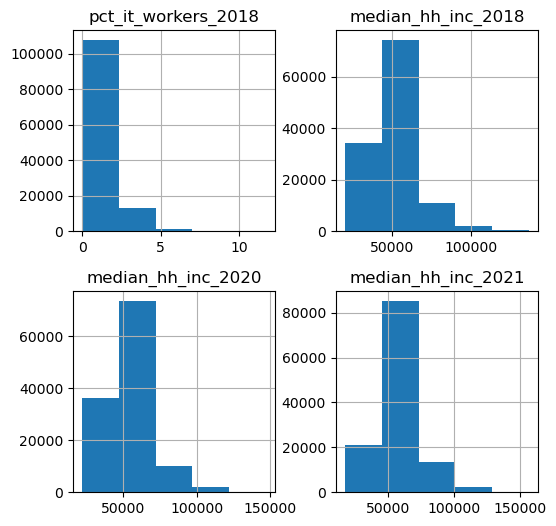

In [21]:
#showing the distribution of the columns with null values
data1 = df_trainMerged[['pct_it_workers_2018','median_hh_inc_2018', 'median_hh_inc_2020', 'median_hh_inc_2021']]
data1.hist(bins = 5, figsize=(6,6))
plt.show()

- The null columns are skewed to the left they are also numerical, therfore, I would be  using the median value for replacing the missing values.


In [22]:
#filling the null values with the median
df_trainMerged['pct_it_workers_2018']= df_trainMerged['pct_it_workers_2018'].fillna(df_trainMerged['pct_it_workers_2018'].median())
df_trainMerged['median_hh_inc_2018']= df_trainMerged['median_hh_inc_2018'].fillna(df_trainMerged['median_hh_inc_2018'].median())
df_trainMerged['median_hh_inc_2020']= df_trainMerged['median_hh_inc_2020'].fillna(df_trainMerged['median_hh_inc_2020'].median())
df_trainMerged['median_hh_inc_2021']= df_trainMerged['median_hh_inc_2021'].fillna(df_trainMerged['median_hh_inc_2021'].median())

## Exploratory Data Analysis

### Most frequent Counties

In [23]:
def chart_plot(plot_data, y, x, title,  yaxis_title, xaxis_title, color_continuous_scale):
    plt.rcParams["figure.figsize"] = (8,6)
    fig = px.bar(plot_data, y= y, x = x, color = x,  color_continuous_scale = color_continuous_scale,
                 labels={'county':'state county'}, height=500,
                title = title )

    # fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.update_layout(yaxis = dict(autorange = 'reversed'),
                       title = dict(
                        x = 0.5,
                        y = 0.95,
                    font = dict(
                    family = 'Arial',
                    color = '#000000')),
                      yaxis_title =  yaxis_title,
                      xaxis_title =  xaxis_title,
            autosize = False,
            width = 700)

    #showing the chart
    fig.show()

In [24]:
#grouping the country based on their count in a descending order
top_county = df_trainMerged['county'].groupby(df_trainMerged['county']).size().sort_values(ascending = False)
top_county = top_county.reset_index(name='counts')
top_county = top_county.head(10)
chart_plot(top_county, 'county', 'counts', 'Most frequent Counties', 'county', 'counts', 'mint')

The most microbusinesses are located in Washington, Jefferson County, Franklin County, and other places.

### Counties with the highest average microbusinesses densities

In [25]:
top_countyM = df_trainMerged.groupby('county')['microbusiness_density'].mean().sort_values(ascending=False)
top_countyM = top_countyM.reset_index()
top_countyM = top_countyM.head(10)
chart_plot(top_countyM, 'county', 'microbusiness_density', 'Counties with the highest density of microbusinesses', 'county', 'microbusiness_density', 'tealrose')

Carson City, Rio Grande and Boundary county have highest average microbusiness density

### The most active counties for microbusinesses

In [26]:
active_countyM = df_trainMerged.groupby('county')['active'].sum().sort_values(ascending=False)
active_countyM = active_countyM.reset_index()
active_countyM = active_countyM.head(10)
chart_plot(active_countyM, 'county', 'active', 'the most active counties for microbusinesses', 'county', 'active_microbusiness', 'tempo')

In [27]:
df_TrainedMerged = df_trainMerged.groupby('month')['microbusiness_density'].mean().reset_index()

#plotting the chart
plt.rcParams["figure.figsize"] = (10,8)
fig = px.line(df_TrainedMerged, x="month", y="microbusiness_density")
fig.update_traces(line=dict( width=3.0))
fig.update_traces(line_color='#456987')


fig.update_layout(title_text ='average microbusiness densities by months', yaxis_title = 'average microbusiness density',
                  xaxis_title = 'month')
#setting the chart properties
fig.update_layout(
    autosize=False,
    width=700,
    height=600,)

#showing the chart
fig.show()

The month of October has the highest average(Peak Period) microbusiness density, followed by the months of July and April.

- Let's look into the number of counties in each state first. To quote Wikipedia:

Texas has the most counties with 254 while Delaware has the fewest with only 3. However, there is one exceptional state: District of Columbia, which also has its own county.

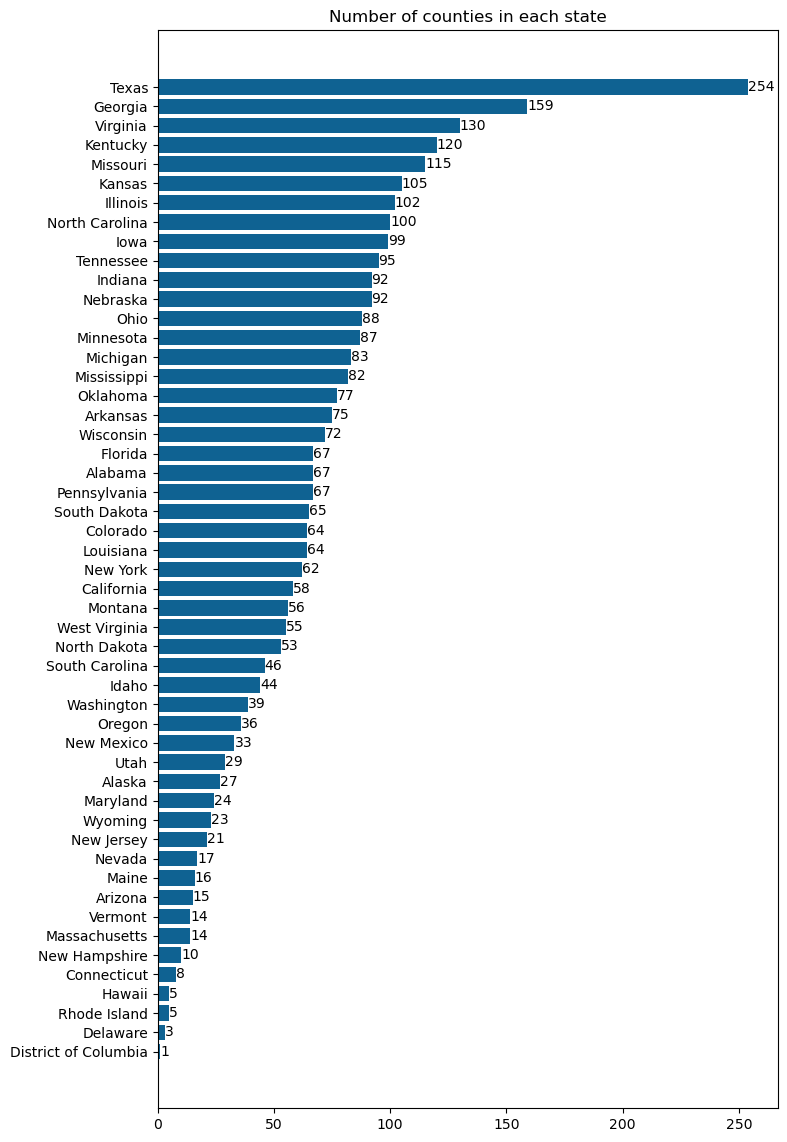

In [28]:
state_c = df_trainMerged[['state', 'cfips']].drop_duplicates(subset=['cfips']).groupby(['state']).size().sort_values()
fig, ax = plt.subplots(figsize=(8,14))
bars = ax.barh(state_c.index, state_c.values,  color='#0F6292')
ax.bar_label(bars)
ax.set_title('Number of counties in each state')
plt.show()

- This is a confirmation to the assertions made on wikipedia

In [29]:
df_trainMerged[['microbusiness_density', 'active']]

,microbusiness_density,active
0,3.007682,1249
1,2.884870,1198
2,3.055843,1269
3,2.993233,1243
4,2.993233,1243
...,...,...
122260,1.803249,101
122261,1.803249,101
122262,1.785395,100
122263,1.785395,100


In [30]:
df_trainMerged["microbusiness_density"].corr(df_trainMerged["active"])

0.3169811826046079

- There is weak correlation between the density of operating microbusinesses and their densities.

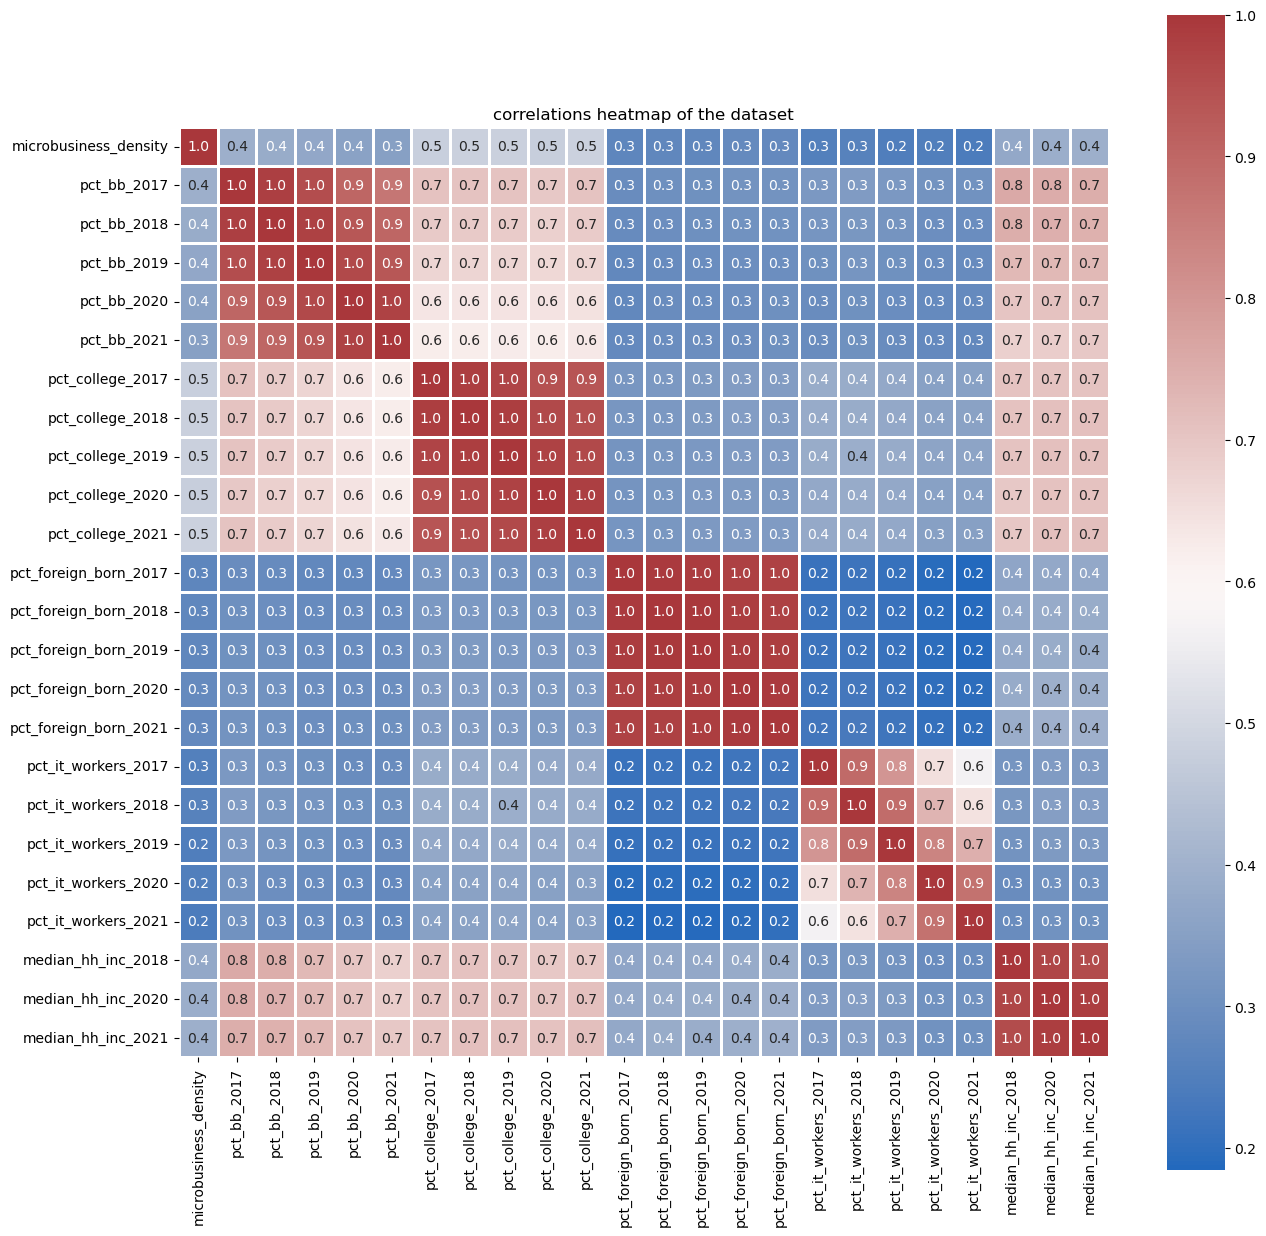

In [31]:
data_float =  df_trainMerged.select_dtypes(include="float")
plt.figure(figsize=(15,15))
sns.heatmap(data_float.corr(), annot=True,  square=True, linecolor='white',linewidths = 2, fmt= '.1f', cmap="vlag")
plt.title('correlations heatmap of the dataset', fontsize= 12)
plt.show()

It is evident that independent characteristics themselves exhibit many collinearities.

## Conclusions
From the overall analysis, certain conclusions have been drawn, which include the following:
Areas with the highest concentration of microbusinesses include Washington, Jefferson County, Franklin County, and other regions. Los Angeles, Orange County, Maricopa County, and other locations have the most active microbusinesses. Carson City, Rio Grande, and Boundary County have the greatest average microbusiness density.
The highest average (Peak Period) microbusiness density is found in the month of October, followed by the months of July and April. Independent features clearly show a great deal of collinearity.

In [32]:
#for data prediction analysis
df_trained2 = df_trainMerged.copy()


In [33]:
df_trained2 = df_trained2.drop(['cfips', 'county','state', 'first_day_of_month', 'active', 'year', 'month', 'pct_bb_2017', 
                                'pct_bb_2018', 'pct_bb_2019',  'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018',
                                'pct_college_2019', 'pct_college_2020', 'pct_college_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
                                'pct_it_workers_2019','pct_it_workers_2020','pct_it_workers_2021','pct_foreign_born_2017',
                               'pct_foreign_born_2018','pct_foreign_born_2019','pct_foreign_born_2020','pct_foreign_born_2021',
                               'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021'], axis=1)

In [34]:
df_trained2

,row_id,microbusiness_density
0,1001_2019-08-01,3.007682
1,1001_2019-09-01,2.884870
2,1001_2019-10-01,3.055843
3,1001_2019-11-01,2.993233
4,1001_2019-12-01,2.993233
...,...,...
122260,56045_2022-06-01,1.803249
122261,56045_2022-07-01,1.803249
122262,56045_2022-08-01,1.785395
122263,56045_2022-09-01,1.785395


In [35]:
df_trained2.to_csv('new_train2.csv', index = False) 